In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.6 MB/s eta 0:00:00


In [2]:
!unzip /content/UTKFace_test.zip

Archive:  /content/UTKFace_test.zip
   creating: UTKFace/
  inflating: UTKFace/27_0_2_20170116184844591.jpg.chip.jpg  
  inflating: UTKFace/26_1_1_20170112205853539.jpg.chip.jpg  
  inflating: UTKFace/26_1_1_20170116232349861.jpg.chip.jpg  
  inflating: UTKFace/24_1_1_20170112231342878.jpg.chip.jpg  
  inflating: UTKFace/49_0_0_20170109001612820.jpg.chip.jpg  
  inflating: UTKFace/58_0_0_20170111210401778.jpg.chip.jpg  
  inflating: UTKFace/40_1_0_20170109132716930.jpg.chip.jpg  
  inflating: UTKFace/26_0_3_20170119180345268.jpg.chip.jpg  
  inflating: UTKFace/3_1_0_20161219225130536.jpg.chip.jpg  
  inflating: UTKFace/39_0_1_20170104200618034.jpg.chip.jpg  
  inflating: UTKFace/4_1_0_20170109193813519.jpg.chip.jpg  
  inflating: UTKFace/26_0_2_20170116161324238.jpg.chip.jpg  
  inflating: UTKFace/30_0_0_20170117181320940.jpg.chip.jpg  
  inflating: UTKFace/26_1_0_20170116192554607.jpg.chip.jpg  
  inflating: UTKFace/26_0_3_20170119180329325.jpg.chip.jpg  
  inflating: UTKFace/26_0_0_2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, Input
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import tempfile
from tqdm import tqdm
import pandas as pd


import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

### this code is tested on (tensrflow v2.8.2)
print(tf.__version__)


2.11.0


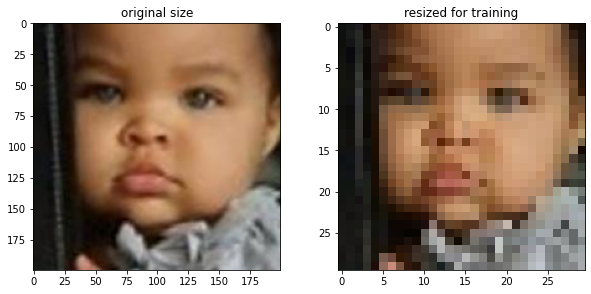

In [5]:
# ### test img size 
test_size = 30
test_img = './UTKFace/3_1_4_20170103210847515.jpg.chip.jpg'
test_img = cv2.imread(test_img)

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
# plt.axis('off')
plt.title('original size')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 2)
resized = cv2.resize(test_img, (test_size,test_size))
# plt.axis('off')
plt.title('resized for training')
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
### select model

DATADIR = '/content/UTKFace'



# [age]_[gender]_[race]_[date&time].jpg
# [age] is an integer from 0 to 116, indicating the age
# [gender] is either 0 (male) or 1 (female)
# [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
# [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace





# MODEL = 'face'
MODEL = 'gender'
# MODEL = 'age'


if MODEL == 'race':
  CATEGORIES = ['White', 'Black', 'Asian', 'Indian', 'Others']
if  MODEL == 'gender':
  CATEGORIES = ['Male', 'Female']
if MODEL == 'age':
  CATEGORIES = [i for i in range(116)]

print(CATEGORIES)


['Male', 'Female']


In [7]:
### define img size 
size = 224


### load imgs
try:
  del data
  print('data delete success')
except:
  print('no data to delete')
  pass

def create_training_data():
    data = []
    path = os.path.join(DATADIR)
    for img in tqdm(os.listdir(path)):
        x = img
        x = x[:-4]
        y = x.split('_')

        if x == None:
            continue
        if MODEL == 'age':
          label = y[0]
        if MODEL == 'gender':
          label = y[1]
        if MODEL == 'race':
          label = y[2]
        converted = cv2.imread(os.path.join(path,img))
        new = cv2.resize(converted, (size,size))
        # print(label)
        data.append([new, int(label)])

    return data

data = create_training_data()
print(len(data))


no data to delete


100%|██████████| 2964/2964 [00:02<00:00, 1376.08it/s]

2964


In [8]:
### reduce data if required
# x= data
# # skipping every nth element
# n = 2
# # declaring new list
# new_arr = []
# # maintaining cntr
# cntr = 0

# # looping over array
# for i in x:
# 	# checking if element is nth pos
# 	if(cntr % n != 0):
# 		new_arr.append(i)
		
# 	# incrementing counter
# 	cntr += 1

# print(len(new_arr))
# data = new_arr

In [9]:

### shuffle data
random.shuffle(data)
random.shuffle(data)
random.shuffle(data)

# data = data[:5000]
print(len(data))
print(CATEGORIES)


2964
['Male', 'Female']


{'Male': 1547, 'Female': 1417}


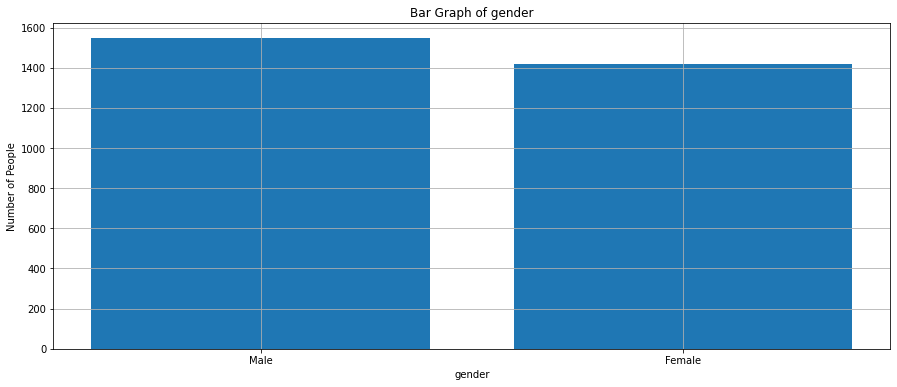

In [10]:
### plot graph
dict_labels = {}
for item in data:
    dict_labels[item[1]] = dict_labels.get(item[1], 0) + 1
if MODEL == 'age':
  dict_labels2={8: 0,9: 0}
  dict_labels.update(dict_labels2)
else:
  pass    

dict_labels = dict(sorted(dict_labels.items()))
dict_labels

result = {}
for key, value in dict_labels.items():
    result[CATEGORIES[key]] = value

print(result)
plt_data = result.copy()
names = list(plt_data.keys())
values = list(plt_data.values())
plt.figure(figsize=(15,6))
plt.bar(range(len(plt_data)), values, tick_label=names)
plt.title("Bar Graph of "+MODEL, y = 1)
plt.xlabel(MODEL)
plt.ylabel('Number of People')
plt.grid(True) 
plt.show()

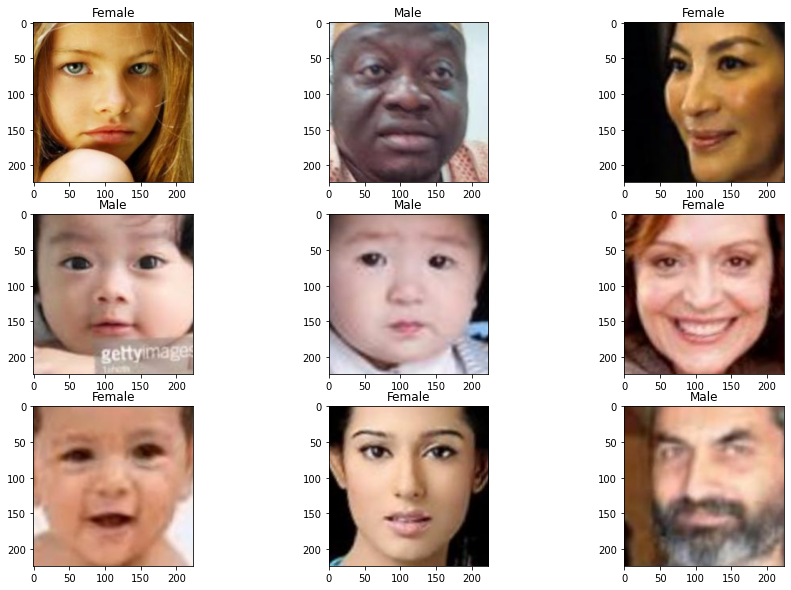

(2964, 224, 224, 3)
(2964,)


In [11]:
### plot data
random.shuffle(data)
plt.figure(figsize=(15,10))
for i in range(9):
  plt.subplot(330 + 1 + i)

  # plt.axis('off')
  for cat,_ in enumerate(CATEGORIES): 
    if data[i][1] == int(cat):
      label= CATEGORIES[cat]

  plt.title(label)
  plt.imshow(cv2.cvtColor(data[i][0], cv2.COLOR_BGR2RGB))
# show the figure
plt.show()

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, size, size, 3)
y = np.array(y)

print(X.shape)
print(y.shape)


In [12]:

### create model
try:
  del model
  print('model delete success')
except:
  print('no model to delete')
  pass



# Hotfix function for debuging
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

# Run the function if case of any keras error
# make_keras_picklable()


no model to delete


In [13]:

### test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=32)


In [14]:
#### MODEL
model = models.Sequential()
model.add(layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu', input_shape=(size, size, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu', input_shape=(size, size, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
# model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
# model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=2))
# model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
# model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=len(CATEGORIES), activation='sigmoid',name=MODEL, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.01)))


model.compile(optimizer='adam',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 36)      1008      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 36)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 36)      11700     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 36)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        20800     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

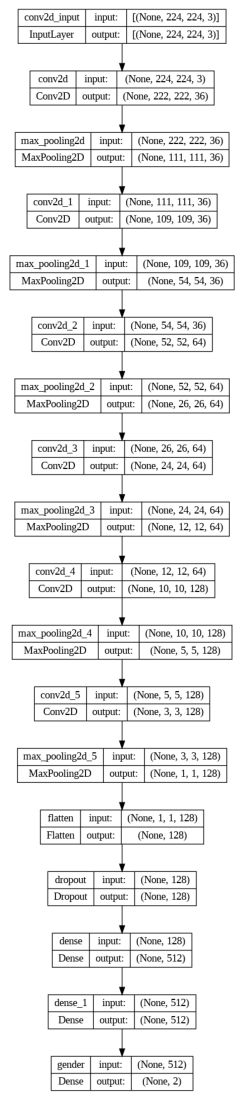

In [15]:

### generate model network as img
dot_img_file = '/tmp/model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
plt.figure(figsize=(15,20))
model_img = cv2.imread(dot_img_file)
plt.axis('off')
plt.imshow(model_img)
plt.savefig(MODEL+'_model.png') 
plt.show()


In [16]:

### train
checkpoint_filepath = './'+MODEL+'_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',   ###auto,max,min
    save_best_only=True)

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=1,
    mode='auto',   ###auto,max,min
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(X_train, y_train, validation_split=0.03, epochs=100, \
          batch_size=16, verbose=0, callbacks=[tqdm_callback, model_checkpoint_callback, early_stop])


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/171           ETA: ?s - 

/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 2/100


0/171           ETA: ?s - 

Epoch 3/100


0/171           ETA: ?s - 

Epoch 4/100


0/171           ETA: ?s - 

Epoch 5/100


0/171           ETA: ?s - 

Epoch 6/100


0/171           ETA: ?s - 

Epoch 7/100


0/171           ETA: ?s - 

Epoch 8/100


0/171           ETA: ?s - 

Epoch 9/100


0/171           ETA: ?s - 

Epoch 10/100


0/171           ETA: ?s - 

Epoch 11/100


0/171           ETA: ?s - 

Epoch 12/100


0/171           ETA: ?s - 

Epoch 13/100


0/171           ETA: ?s - 

Epoch 14/100


0/171           ETA: ?s - 

Epoch 15/100


0/171           ETA: ?s - 

Epoch 16/100


0/171           ETA: ?s - 

Epoch 17/100


0/171           ETA: ?s - 

Epoch 18/100


0/171           ETA: ?s - 

Epoch 19/100


0/171           ETA: ?s - 

Epoch 20/100


0/171           ETA: ?s - 

Epoch 21/100


0/171           ETA: ?s - 

Epoch 22/100


0/171           ETA: ?s - 

Epoch 23/100


0/171           ETA: ?s - 

Epoch 24/100


0/171           ETA: ?s - 

Epoch 25/100


0/171           ETA: ?s - 

Epoch 26/100


0/171           ETA: ?s - 

Epoch 27/100


0/171           ETA: ?s - 

Epoch 28/100


0/171           ETA: ?s - 

Epoch 29/100


0/171           ETA: ?s - 

Restoring model weights from the end of the best epoch: 17.
Epoch 29: early stopping


In [ ]:

### plot training history
print(history.keys())
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--')
plt.savefig(MODEL+'_model_training_acc.png')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--')
plt.savefig(MODEL+'_model_training_loss.png')
plt.show()


In [18]:


### evaluate model
from tensorflow.keras.models import load_model
model = load_model('./'+MODEL+'_model.h5')
test_loss, test_acc = model.evaluate(X_test,  y_test, callbacks=[tqdm_callback], verbose=0)
print('\nTest accuracy:', test_acc)




0/5           ETA: ?s - Evaluating


Test accuracy: 0.7852349281311035


5/5 [==============================] - 0s 9ms/step


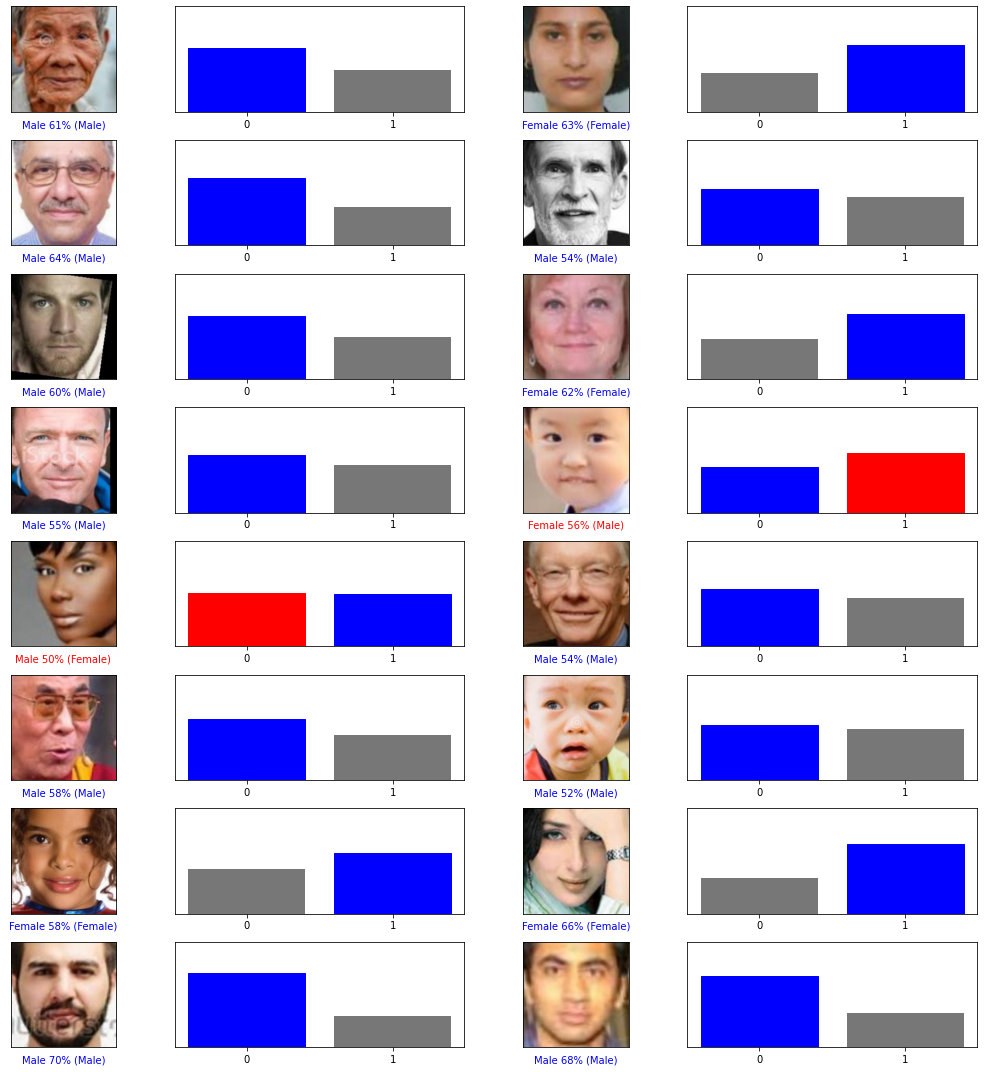

In [19]:

### plot predictions 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test)
predictions[0]

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(CATEGORIES[predicted_label],
                                100*np.max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(CATEGORIES)))
  plt.yticks([])
  thisplot = plt.bar(range(len(CATEGORIES)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


num_rows = 8
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(15,15))
# plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.savefig(MODEL+'_model_training_results.png')
plt.show()


In [20]:

### confision matrix
print(model.output_shape)
from seaborn.rcmod import reset_orig
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

ypred = model.predict(X_test, verbose=1)

res = []
for i in tqdm(ypred):
  # print(i)
  # print(np.argmax(i))

  try:
    # result = 0 if i > 0.5 else 1                    ### for binary
   result = np.argmax(i)                         ### for categorical, mse
  except:
    pass
  res.append(result)


target_names = []
for i in list(set(res)):
  # print(CATEGORIES[i])
  target_names.append(CATEGORIES[i])

print(classification_report(y_test, res, target_names=target_names))


(None, 2)
5/5 [==============================] - 0s 15ms/step


100%|██████████| 149/149 [00:00<00:00, 129362.72it/s]

              precision    recall  f1-score   support

        Male       0.85      0.77      0.81        88
      Female       0.71      0.80      0.75        61

    accuracy                           0.79       149
   macro avg       0.78      0.79      0.78       149
weighted avg       0.79      0.79      0.79       149



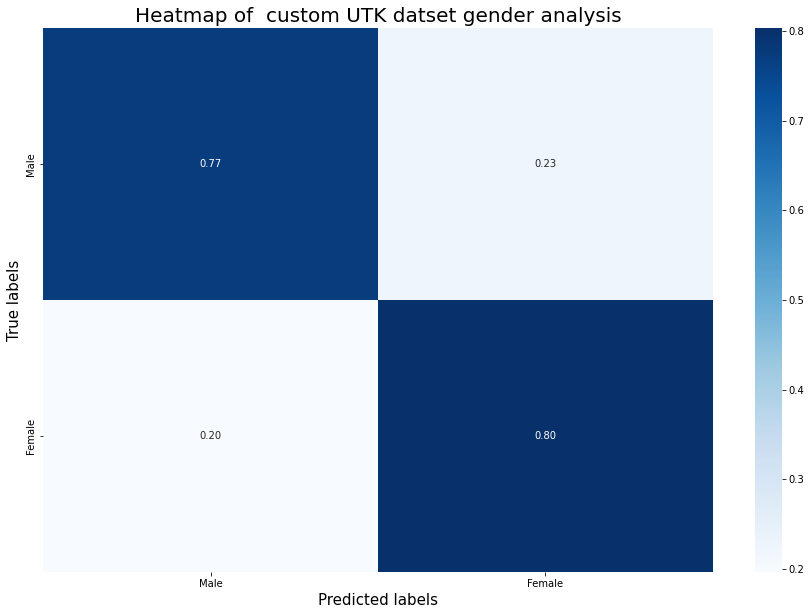

In [21]:

### confusion matrix plot
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

class_names = CATEGORIES
# normalize the confusion matrix
cm = confusion_matrix(y_test, res)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
plt.figure(figsize = (15,10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Heatmap of '+' custom UTK datset '+MODEL+' analysis', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted labels', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True labels', fontsize = 15) # y-axis label with fontsize 15
plt.savefig(MODEL+'_model_confusionMatrix.png')
plt.show()

In [22]:

### save all files in zip
!zip -r gender.zip /content/gender_model*


  adding: content/gender_model_confusionMatrix.png (deflated 20%)
  adding: content/gender_model.h5 (deflated 8%)
  adding: content/gender_model.png (deflated 20%)
  adding: content/gender_model_training_results.png (deflated 2%)
